### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

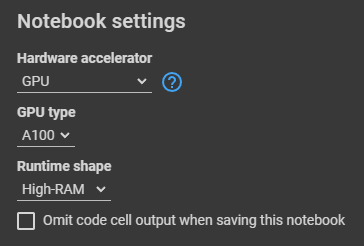

This exercise (using the sample data) will take ~40GB of GPU RAM.

# Instruct-tuning LLaMA 2 using `peft`, `transformers` and `bitsandbytes`

This notebook should guide you through a short example of fine-tuning "structure". While this is not all that this process is capable of, it should serve to highlight some key pieces of the flow that you can extend!

Today, we'll be fine-tuning [LLaMA 2](https://huggingface.co/meta-llama/Llama-2-7b-hf) a large language model trained by the BigScience team. The full paper is available [here](https://arxiv.org/abs/2307.09288)!

The general idea here is that instead of relying on the model to do zero-shot, one-shot, or few-shot in-context learning - we're going to show it many examples and let it retrain weights based off of those examples. Effectively moving the prompt-engineering piece of the puzzle into fine-tuning.

We can use the [Alpaca-GPT-4 dataset](https://huggingface.co/datasets/c-s-ale/alpaca-gpt4-data) to fine-tune LLaMA 2 to be able to follow instructions better!

### Overview of PEFT and LoRA:

Based on some awesome new research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

### Install requirements

First, run the cells below to install the requirements:

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00


### Model loading

Let's load the `meta-llama/Llama-2-7b-hf` model!

We're also going to load the `meta-llama/Llama-2-7b-hf` tokenizer.

This step will take some time, as we have to download the model weights which are ~10GB.

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "meta-llama/Llama-2-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's also load the tokenizer, along with the padding token.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#### Model Architecture

It's important to observe the model's construction so you can ensure you know which modules you should apply LoRA to.

As per the paper, we're going to focus on the attention weights - so keep an eye out for modules like: `q_proj`, `v_proj`, `query_key_value`. This is model dependent - if you have any question - please feel free to ask!

For the QLoRA process, we'll follow the guidance of the paper and apply LoRA to all possible layers.

Exerpt from the [paper](https://arxiv.org/pdf/2305.14314.pdf)

>Default LoRA hyperparameters do not match 16-bit performance When using the standard practice of applying LoRA to query and value attention projection matrices, we are not able to replicate full finetuning performance for large base models.
As shown in Figure 2 for LLaMA 7B finetuning on Alpaca, we find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers are required to match full finetuning performance.

In [ ]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

### Apply LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

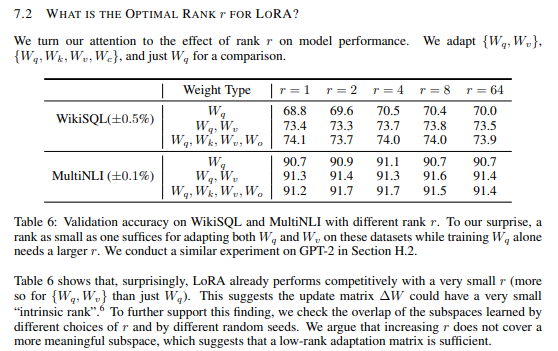


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. While the LoRA paper suggests applying it to only the Attention weights, we'll be following the guidance of the QLoRA paper and applying LoRA to all Linear layers.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    #target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

base_model = prepare_model_for_kbit_training(base_model)
model = get_peft_model(base_model, lora_config)
print_trainable_parameters(model)

trainable params: 33554432 || all params: 3533967360 || trainable%: 0.9494833591219133


### Preprocessing

We can simply load our dataset from 🤗 Hugging Face with the `load_dataset` method!

In [ ]:
import transformers
from datasets import load_dataset

dataset_name = "c-s-ale/alpaca-gpt4-data"

In [ ]:
dataset = load_dataset(dataset_name)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 52002
    })
})


In [ ]:
print(dataset['train'][0])

{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'}


In [ ]:
print(dataset['train'][5])

{'instruction': 'Identify the odd one out.', 'input': 'Twitter, Instagram, Telegram', 'output': 'The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.'}


As we're only doing a sample - let's limit the number of samples we'll train on to 5K.

In [ ]:
dataset_subset = dataset["train"].select(range(5_000))

We want to put our data in the form:

```
### INSTRUCTION
Give three tips for staying healthy.

### OUTPUT
1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.
```

Or, if we have an input as well as an instruction:

```
### INSTRUCTION
Identify the odd one out.

### INPUT
Twitter, Instagram, Telegram

### OUTPUT
The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.
```


The more general idea here is that we want to show our model examples of a prompt, and its completion.

Say you were fine-tuning a Natural Language to SQL task.

In that case - the data should be moved into the following format:

```
### INSTRUCTION
Please convert the following context into an SQL query.

### CONTEXT
How many people work at my company?

### SQL
SELECT COUNT(*) FROM employees
```

In [ ]:
def generate_prompt(example, return_response=True) -> str:
  full_prompt = f"### INSTRUCTION:\n{example['instruction']}"
  if input != "":
    full_prompt += f"\n\n### INPUT:\n{example['input']}"
  full_prompt += f"\n\n### OUTPUT:\n"

  if return_response:
    full_prompt += f"{example['output']}"
  return full_prompt

The `Trainer` class contains all the usual suspects - these are the same hyper-parameters you know and love from traditional ML applications!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="llama-2-7b-instruct",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit", # from the QLoRA paper
    logging_steps=1,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True, # ensure proper upcasting for compute dtypes
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=True
)

In [ ]:
!pip install trl -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
from trl import SFTTrainer

max_seq_length = 2048

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_subset,
    peft_config=lora_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=generate_prompt,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:465: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.3126, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 1.273, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 1.1778, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 1.1202, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.1057, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.0656, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.046, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.1057, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.084, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 1.0695, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 1.0228, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 1.0243, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 1.0645, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 1.0081, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.9865, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.9953, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 1.0053, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 1.0049, 'learning_rate': 0.0

TrainOutput(global_step=120, training_loss=0.9438853512207667, metrics={'train_runtime': 1075.2694, 'train_samples_per_second': 9.3, 'train_steps_per_second': 1.162, 'train_loss': 0.9438853512207667, 'epoch': 1.1})

In [ ]:
trainer.save_model()

In [ ]:
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    training_args.output_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(training_args.output_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
sample = dataset_subset[5]

prompt = generate_prompt(sample, return_response=False)

In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()

outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9, temperature=0.5)

In [ ]:
print(f"Prompt:\n{prompt}\n")
print(f"-------------")
print(f"Generated instruction:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"-------------")
print(f"Ground truth:\n{sample['output']}")

Prompt:
### INSTRUCTION:
Identify the odd one out.

### INPUT:
Twitter, Instagram, Telegram

### OUTPUT:


-------------
Generated instruction:
The odd one out is Telegram.
-------------
Ground truth:
The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.


In [ ]:
model_id = "meta-llama/Llama-2-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

untuned_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()

outputs = untuned_model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9, temperature=0.5)

In [ ]:
print(f"Prompt:\n{prompt}\n")
print(f"-------------")
print(f"Generated instruction:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"-------------")
print(f"Ground truth:\n{sample['output']}")

Prompt:
### INSTRUCTION:
Identify the odd one out.

### INPUT:
Twitter, Instagram, Telegram

### OUTPUT:


-------------
Generated instruction:
Facebook

### EXPLANATION:
Facebook is the only one that is a social media platform.

-------------
Ground truth:
The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.
